# Six Southern Labor Markets #6
### Unemployment type and duration

February 26, 2019

Brian Dew, @bd_econ

-----

For the combined years 2016, 2017, and 2018, look at why people are unemployed and how this compares to national average. Then look at how unemployment duration is divided between short- (<5 weeks), medium- (5-26 weeks), and long-term (27+ weeks) unemployment.

Areas:

- Chattanooga
- Knoxville
- Greenville
- Asheville
- Kingsport
- Huntsville
- US total

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [2]:
areas = [('Chattanooga-Cleveland-Dalton, TN-GA', 'CSA', [174]),
         ('Greenville-Anderson-Spartanburg, SC', 'CSA', [273]),
         ('Asheville, NC', 'CBSA', [11700]),
         ('Johnson City-Kingsport-Bristol, TN-VA', 'CSA', [304]),
         ('Huntsville, AL', 'CBSA', [26620]),
         ('Knoxville, TN', 'CBSA', [28940])]

area_names = [area[0] for area in areas]

In [3]:
csa = [area[2][0] for area in areas if area[1] == 'CSA']
cbsa = [area[2][0] for area in areas if area[1] == 'CBSA']
grps = [('US Total', 'AGE > -1')]
grps2 = [(area[0], f'{area[1]} == {area[2][0]}') for area in areas]
groups = grps2 + grps

# Unemployment type

In [4]:
# CPS data
os.chdir('/home/brian/Documents/CPS/data/clean')

# Subset of columns of interest
columns = ['MONTH', 'YEAR', 'CBSA', 'CSA', 'AGE', 'STATE', 'REGION',
           'BASICWGT', 'LFS', 'UNEMPTYPE', 'UNEMPDUR']

df = pd.concat([pd.read_feather(f'cps{year}.ft', columns=columns)
                for year in [2016, 2017, 2018]])

In [5]:
# Collect results for total, men, women in each area
results = pd.DataFrame()
for group in groups:
    data = df.query(group[1])
    data = data.query('AGE >= 16')
    u = data.groupby('UNEMPTYPE').BASICWGT.sum()
    lf = data[data['LFS'] != 'NILF'].BASICWGT.sum()
    s = ((u / lf) * 100)
    for idx, val in s.iteritems():
        results.at[group[0], idx] = val 
        
results = results.drop('nan', axis=1)
results['Total'] = results.sum(axis=1)

In [6]:
areas = results[results.index != 'US Total']
total = results[results.index == 'US Total']

areas = areas.sort_values(by='Total')

results = pd.concat([total, areas]).drop('Total', axis=1)
label_locs = results.cumsum(axis=1) - results.divide(2)

In [7]:
results

,Job Leaver,Job Loser,New Entrant,Re-entrant
US Total,0.504433,2.107583,0.442542,1.315879
"Asheville, NC",0.372209,1.447538,0.279831,0.790547
"Knoxville, TN",0.629139,1.105258,0.416987,1.313944
"Greenville-Anderson-Spartanburg, SC",0.426098,1.819097,0.312064,1.375730
"Johnson City-Kingsport-Bristol, TN-VA",0.939859,1.671698,0.172478,1.180108
"Chattanooga-Cleveland-Dalton, TN-GA",0.795606,1.855047,0.646967,1.306082
"Huntsville, AL",0.371496,2.147555,0.801583,1.778237


#### Graph results

In [8]:
os.chdir('/home/brian/Documents/blog_posts/Southern_Six/')

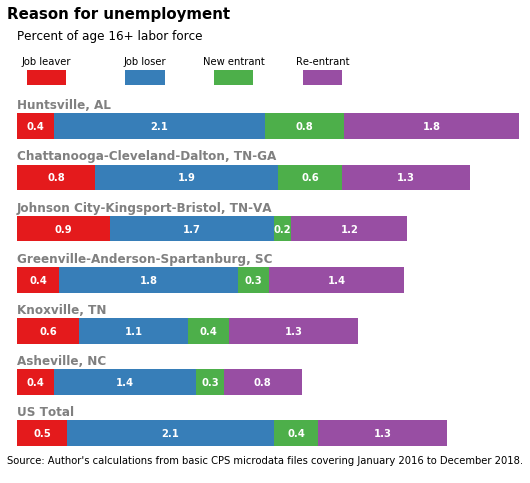

In [9]:
# Stacked horizontal bar chart
fig = plt.figure(figsize=(9,8))

ax = plt.gca()

# Stacked horizontal bar plot
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
results.plot(kind='barh', stacked=True, width=0.5, legend=None, 
             color=colors, ax=ax)

plt.yticks([])

for y_loc, name in enumerate(results.index):
    plt.text(0, y_loc + 0.34, name, fontsize=12, color='gray', weight='bold')
    
for category in label_locs:
    for y_loc, x_loc in enumerate(label_locs[category]):
        text_val = round(results[category].iloc[y_loc], 1)
        plt.text(x_loc, y_loc - 0.07, text_val, weight='bold',
                 fontsize=10, color='white', ha='center')

plt.ylim(-0.5, 8)
plt.xlim(0, 5.1)
        
# Custom legend at top of plot
plt.text(0.3, 7.2, 'Job leaver', ha='center')
rect = Rectangle((0.1, 6.8), 0.4, 0.3, facecolor='#e41a1c', edgecolor='none')
ax.add_patch(rect)

plt.text(1.3, 7.2, 'Job loser', ha='center')
rect = Rectangle((1.1, 6.8), 0.4, 0.3, facecolor='#377eb8', edgecolor='none')
ax.add_patch(rect)

plt.text(2.2, 7.2, 'New entrant', ha='center')
rect = Rectangle((2.0, 6.8), 0.4, 0.3, facecolor='#4daf4a', edgecolor='none')
ax.add_patch(rect)

plt.text(3.1, 7.2, 'Re-entrant', ha='center')
rect = Rectangle((2.9, 6.8), 0.4, 0.3, facecolor='#984ea3', edgecolor='none')
ax.add_patch(rect)

# add title and footer
plt.text(-0.1, 8.1, 'Reason for unemployment', 
          fontsize=15, weight='bold')

plt.text(0, 7.7, "Percent of age 16+ labor force", fontsize=12)

plt.text(-0.1, -0.6, "Source: Author's calculations from basic CPS microdata files covering January 2016 to December 2018.")

plt.axis('off')

plt.savefig('unempreason.png', bbox_inches='tight');

### Unemployment duration

In [10]:
# Collect results for total, men, women in each area
results = pd.DataFrame()
for group in groups:
    data = df.query(group[1])
    data = data.query('AGE >= 16')
    lf = data.loc[data['LFS'] != 'NILF', 'BASICWGT'].sum()
    st = data.loc[data['UNEMPDUR'].between(0, 4), 'BASICWGT'].sum() 
    results.at[group[0], 'Short-term'] = st / lf * 100
    mt = data.loc[data['UNEMPDUR'].between(5, 26), 'BASICWGT'].sum()
    results.at[group[0], 'Medium-term'] = mt / lf * 100
    lt = data.loc[data['UNEMPDUR'] > 26, 'BASICWGT'].sum()
    results.at[group[0], 'Long-term'] = lt / lf * 100
        
results['Total'] = results.sum(axis=1)

In [11]:
areas = results[results.index != 'US Total']
total = results[results.index == 'US Total']

areas = areas.sort_values(by='Total')

results = pd.concat([total, areas]).drop('Total', axis=1)
label_locs = results.cumsum(axis=1) - results.divide(2)

In [12]:
results

,Short-term,Medium-term,Long-term
US Total,1.413340,1.911060,1.046037
"Asheville, NC",1.319043,1.282179,0.288904
"Knoxville, TN",1.144946,1.275341,1.045042
"Greenville-Anderson-Spartanburg, SC",1.482869,1.740246,0.709874
"Johnson City-Kingsport-Bristol, TN-VA",1.300875,1.684988,0.978279
"Chattanooga-Cleveland-Dalton, TN-GA",1.424462,2.680056,0.499183
"Huntsville, AL",1.254842,2.055756,1.788273


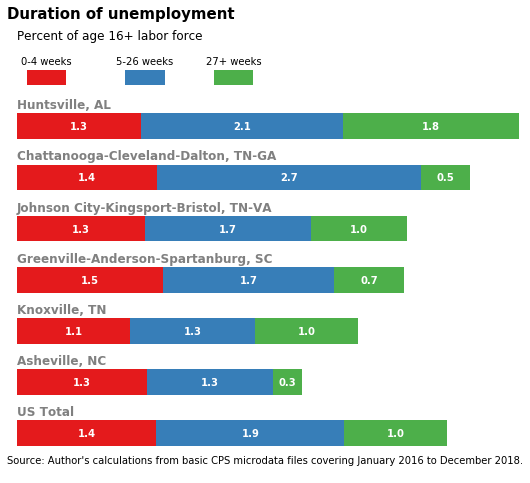

In [13]:
# Stacked horizontal bar chart
fig = plt.figure(figsize=(9,8))

ax = plt.gca()

# Stacked horizontal bar plot
colors = ['#e41a1c', '#377eb8', '#4daf4a']
results.plot(kind='barh', stacked=True, width=0.5, legend=None, 
             color=colors, ax=ax)

plt.yticks([])

for y_loc, name in enumerate(results.index):
    plt.text(0, y_loc + 0.34, name, fontsize=12, color='gray', weight='bold')
    
for category in label_locs:
    for y_loc, x_loc in enumerate(label_locs[category]):
        text_val = round(results[category].iloc[y_loc], 1)
        plt.text(x_loc, y_loc - 0.07, text_val, weight='bold',
                 fontsize=10, color='white', ha='center')

plt.ylim(-0.5, 8)
plt.xlim(0, 5.1)
        
# Custom legend at top of plot
plt.text(0.3, 7.2, '0-4 weeks', ha='center')
rect = Rectangle((0.1, 6.8), 0.4, 0.3, facecolor='#e41a1c', edgecolor='none')
ax.add_patch(rect)

plt.text(1.3, 7.2, '5-26 weeks', ha='center')
rect = Rectangle((1.1, 6.8), 0.4, 0.3, facecolor='#377eb8', edgecolor='none')
ax.add_patch(rect)

plt.text(2.2, 7.2, '27+ weeks', ha='center')
rect = Rectangle((2.0, 6.8), 0.4, 0.3, facecolor='#4daf4a', edgecolor='none')
ax.add_patch(rect)


# add title and footer
plt.text(-0.1, 8.1, 'Duration of unemployment', 
          fontsize=15, weight='bold')

plt.text(0, 7.7, "Percent of age 16+ labor force", fontsize=12)

plt.text(-0.1, -0.6, "Source: Author's calculations from basic CPS microdata files covering January 2016 to December 2018.")

plt.axis('off')

plt.savefig('unempduration.png', bbox_inches='tight');